#线性回归
NOTE: 本示例教程依然在开发中，目前是基于2.0alpha版本的Paddle，未来会迁移到2.0beta版本。

##简要介绍
经典的线性回归模型主要用来预测一些存在着线性关系的数据集。回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。 
本示例简要介绍如何用飞桨开源框架，实现波士顿房价预测。其思路是，假设uci-housing数据集中的房子属性和房价之间的关系可以被属性间的线性组合描述。在模型训练阶段，让假设的预测结果和真实值之间的误差越来越小。在模型预测阶段，预测器会读取训练好的模型，对从未遇见过的房子属性进行房价预测。

##环境设置
本示例基于飞桨开源框架2.0版本。

In [29]:
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

paddle.__version__

'2.0.0-alpha0'

##数据集
本示例采用uci-housing数据集，这是经典线性回归的数据集。数据集共506行,每行14列。前13列用来描述房屋的各种信息，最后一列为该类房屋价格中位数。飞桨提供了读取uci_housing训练集和测试集的接口，分别为paddle.dataset.uci_housing.train()和paddle.dataset.uci_housing.test()。
下面我们来浏览一下数据是什么样子的：

In [30]:
train_data=paddle.dataset.uci_housing.train()
sampledata=next(train_data())
print(sampledata)
print("Number of features: ",len(sampledata[0]))

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))
Number of features:  13


下面我们分别定义了用于训练和测试的数据提供器。提供器每次读入一个大小为BATCH_SIZE的数据批次。如果您希望加一些随机性，它可以同时定义一个批次大小和一个缓存大小。这样的话，每次数据提供器会从缓存中随机读取批次大小那么多的数据。

In [31]:
BATCH_SIZE=20
BUF_SIZE=500

train_reader=paddle.batch(paddle.reader.shuffle(paddle.dataset.uci_housing.train(),buf_size=BUF_SIZE),batch_size=BATCH_SIZE)

#配置网络结构
线性回归是一个从输入到输出的简单的全连接层。
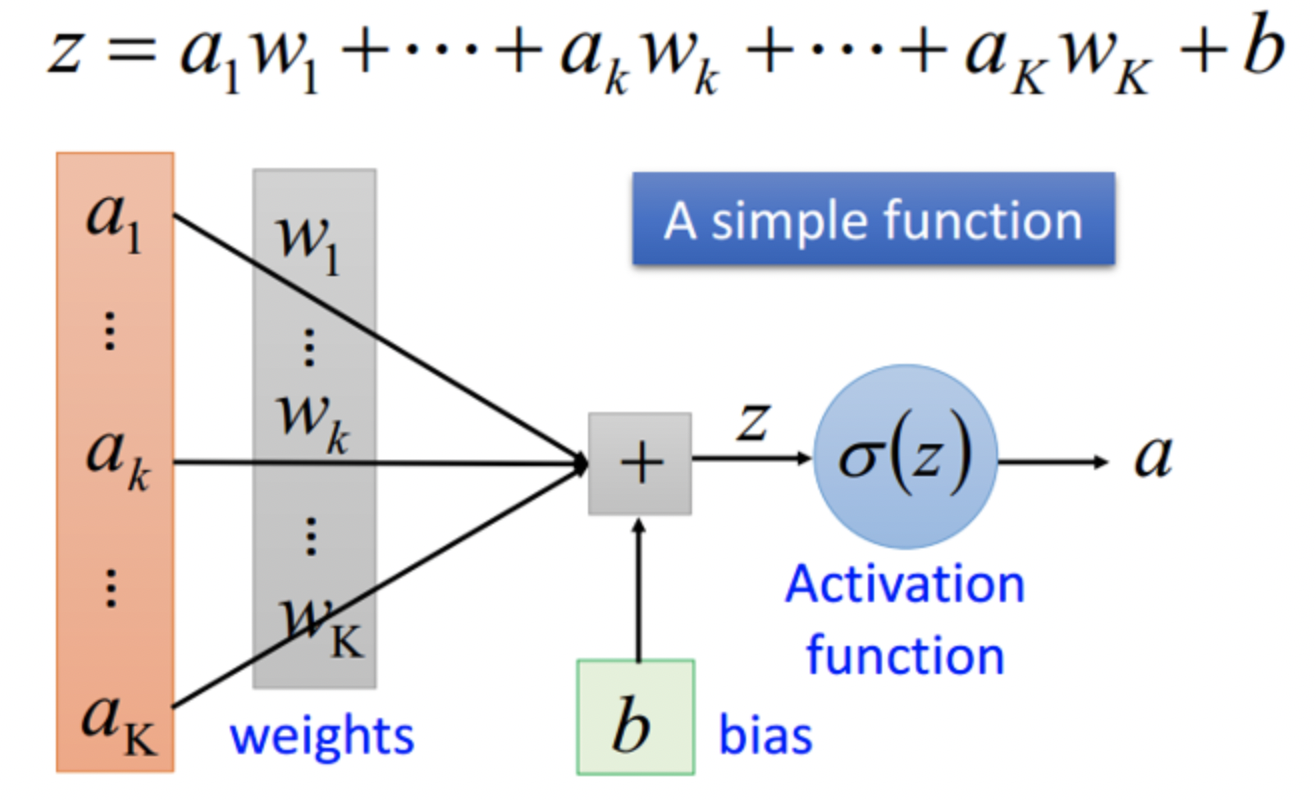

In [32]:
class Regressor(paddle.nn.Layer):
  def __init__(self):
    super(Regressor,self).__init__()
    self.fc=paddle.nn.Linear(input_dim=13,output_dim=1,act=None)

  def forward(self,inputs):
    pred=self.fc(inputs)
    return pred

##模型训练
下面为大家展示模型训练的代码。

In [33]:
def train(model):
  print('start training ... ')
  model.train()
  EPOCH_NUM=2
  optimizer=paddle.optimizer.SGDOptimizer(learning_rate=0.001, parameter_list = model.parameters())
  for epoch_id in range(EPOCH_NUM):
    train_cost=0
    for batch_id,data in enumerate(train_reader()):
        with paddle.imperative.guard():
            features_np=np.array([x[0] for x in data],np.float32)
            labels_np=np.array([x[1] for x in data],np.float32)
            features=paddle.imperative.to_variable(features_np)
            labels=paddle.imperative.to_variable(labels_np)
            y_pred=model(features)
            cost=paddle.nn.functional.square_error_cost(input=y_pred,label=labels)
            avg_cost=paddle.mean(cost)
            y_predict = model(features)
            opts=optimizer.minimize(avg_cost)
            train_cost = [avg_cost.numpy()]
        if batch_id%10==0:
            print("Pass:%d,Cost:%0.5f"%(epoch_id,train_cost[0]))
            
with paddle.imperative.guard():
    model = Regressor()
    train(model)      

start training ... 
Pass:0,Cost:707.56244
Pass:0,Cost:540.78314
Pass:0,Cost:638.45319
Pass:1,Cost:747.46057
Pass:1,Cost:667.45184
Pass:1,Cost:481.09711


##模型预测


In [35]:
#获取预测数据
INFER_BATCH_SIZE=10
infer_reader=paddle.batch(paddle.dataset.uci_housing.test(),batch_size=INFER_BATCH_SIZE)
infer_data = next(infer_reader())
infer_features_np = np.array([data[0] for data in test_data]).astype("float32")
infer_labels_np= np.array([data[1] for data in test_data]).astype("float32")
with paddle.imperative.guard():
  infer_features=paddle.imperative.to_variable(infer_features_np)
  infer_labels=paddle.imperative.to_variable(infer_labels_np)
  fetch_list=model(infer_features).numpy()
  print(fetch_list)
   
sum_cost=0
for i in range(INFER_BATCH_SIZE):
    infer_result=fetch_list[i][0]
    ground_truth=infer_labels_np[i]
    print("No.%d: infer result is %.2f,ground truth is %.2f" % (i, infer_result,ground_truth))
    cost=np.power(infer_result-ground_truth,2)
    sum_cost+=cost
print("平均误差为:",sum_cost/INFER_BATCH_SIZE)

[[ 0.27139348]
 [ 0.4437772 ]
 [ 0.02264171]
 [ 0.08073261]
 [ 0.06301961]
 [ 0.07857185]
 [-0.06454449]
 [-0.08050428]
 [-0.2496453 ]
 [ 0.00320381]]
No.0: infer result is 0.27,ground truth is 8.50
No.1: infer result is 0.44,ground truth is 5.00
No.2: infer result is 0.02,ground truth is 11.90
No.3: infer result is 0.08,ground truth is 27.90
No.4: infer result is 0.06,ground truth is 17.20
No.5: infer result is 0.08,ground truth is 27.50
No.6: infer result is -0.06,ground truth is 15.00
No.7: infer result is -0.08,ground truth is 17.20
No.8: infer result is -0.25,ground truth is 17.90
No.9: infer result is 0.00,ground truth is 16.30
平均误差为: [316.96146]
